# So Sánh Kích Thước Tập Labeled - Labeled Size Comparison (OPTIMIZED)

## Mục Tiêu
- Thử nghiệm self-training với **3 kích thước labeled data**: 5%, 10%, 20%
- So sánh hiệu quả của self-training khi có ít vs nhiều labeled data
- Trả lời câu hỏi: **Khi nào self-training còn hiệu quả?**
- Tìm điểm **diminishing return** (thêm labeled data không còn cải thiện nhiều)

## Optimization Note
⚡ **Bỏ 1% labeled** (quá ít, model quá yếu, mất ~5-7 phút)  
✅ **Giữ 5%, 10%, 20%** - 3 mức có contrast rõ ràng nhất

## Giả Thuyết
- **5% labeled** (baseline): Sweet spot cho semi-supervised
- **10% labeled**: Model mạnh hơn → Self-training cải thiện ít hơn
- **20% labeled**: Gần supervised → Self-training không cần thiết

## Setup
- Ngưỡng τ = 0.90 (cố định)
- Max iterations = 10
- So sánh: F1-macro improvement vs supervised baseline
- **Tiết kiệm: ~25% thời gian** (từ 20 phút → 15 phút)

In [1]:
# PARAMETERS
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

# Labeled fractions to compare (optimized: 3 configs for clear contrast)
# Bỏ 1% (quá ít, model quá yếu) - Giữ 5% (baseline), 10% (moderate), 20% (high)
LABELED_FRACTIONS = [0.05, 0.10, 0.20]  # 5%, 10%, 20%

# Fixed parameters
TAU = 0.90
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

# Output directory
RESULTS_DIR = "data/processed/labeled_size_experiments"

In [2]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, run_self_training,
    mask_labels_time_aware, time_split, build_feature_columns
)
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Setup paths
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

results_dir = (PROJECT_ROOT / RESULTS_DIR).resolve()
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Results directory: {results_dir}")

Project root: D:\DataEngineer\DataMining\air_guard_mini_project
Results directory: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments


## Load Dataset

In [3]:
# Load original dataset
df_original = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

print("Original dataset shape:", df_original.shape)
print("Original labeled fraction:", df_original['is_labeled'].mean())
print("\nColumns:", df_original.columns.tolist()[:10], "...")

Original dataset shape: (420768, 56)
Original labeled fraction: 0.08671049129211347

Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO'] ...


## Run Experiments for Each Labeled Fraction

In [4]:
results = {}

for frac in LABELED_FRACTIONS:
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: Labeled Fraction = {frac*100:.0f}% (τ={TAU})")
    print(f"{'='*80}")
    
    # Create dataset with specific labeled fraction
    # Re-mask labels to get desired fraction
    df = df_original.copy()
    
    # Calculate missing fraction (inverse of labeled fraction)
    missing_frac = 1.0 - frac
    
    # Create config and re-mask
    data_cfg = SemiDataConfig(
        cutoff=CUTOFF,
        random_state=RANDOM_STATE
    )
    
    df = mask_labels_time_aware(df, data_cfg, missing_fraction=missing_frac)
    
    train_df, test_df = time_split(df, cutoff=CUTOFF)
    labeled_count = train_df['is_labeled'].sum()
    unlabeled_count = (~train_df['is_labeled']).sum()
    
    print(f"Training set:")
    print(f"  - Labeled: {labeled_count:,} ({labeled_count/len(train_df)*100:.1f}%)")
    print(f"  - Unlabeled: {unlabeled_count:,} ({unlabeled_count/len(train_df)*100:.1f}%)")
    print(f"Test set: {len(test_df):,} samples")
    
    # Run self-training
    st_cfg = SelfTrainingConfig(
        tau=TAU,
        max_iter=MAX_ITER,
        min_new_per_iter=MIN_NEW_PER_ITER,
        val_frac=VAL_FRAC
    )
    
    result = run_self_training(df, data_cfg, st_cfg)
    
    # Store results
    results[f"{frac*100:.0f}%"] = {
        "labeled_fraction": frac,
        "labeled_count": int(labeled_count),
        "unlabeled_count": int(unlabeled_count),
        "test_accuracy": result["test_metrics"]["accuracy"],
        "test_f1_macro": result["test_metrics"]["f1_macro"],
        "history": result["history"],
        "per_class_report": result["test_metrics"]["report"],
        "total_pseudo_labels": sum([h["new_pseudo"] for h in result["history"]]),
        "iterations_completed": len(result["history"])
    }
    
    print(f"\n✅ Completed {frac*100:.0f}%:")
    print(f"   Test Accuracy: {result['test_metrics']['accuracy']:.4f}")
    print(f"   Test F1-macro: {result['test_metrics']['f1_macro']:.4f}")
    print(f"   Total pseudo-labels: {results[f'{frac*100:.0f}%']['total_pseudo_labels']:,}")

print(f"\n{'='*80}")
print("ALL EXPERIMENTS COMPLETED")
print(f"{'='*80}")


EXPERIMENT: Labeled Fraction = 5% (τ=0.9)


Training set:
  - Labeled: 991 (0.2%)
  - Unlabeled: 402,785 (99.8%)
Test set: 16,992 samples



✅ Completed 5%:
   Test Accuracy: 0.5633
   Test F1-macro: 0.4671
   Total pseudo-labels: 344,688

EXPERIMENT: Labeled Fraction = 10% (τ=0.9)


Training set:
  - Labeled: 1,982 (0.5%)
  - Unlabeled: 401,794 (99.5%)
Test set: 16,992 samples



✅ Completed 10%:
   Test Accuracy: 0.5678
   Test F1-macro: 0.5050
   Total pseudo-labels: 346,372

EXPERIMENT: Labeled Fraction = 20% (τ=0.9)


Training set:
  - Labeled: 3,963 (1.0%)
  - Unlabeled: 399,813 (99.0%)
Test set: 16,992 samples



✅ Completed 20%:
   Test Accuracy: 0.5759
   Test F1-macro: 0.4896
   Total pseudo-labels: 357,913

ALL EXPERIMENTS COMPLETED


## Save Results to JSON

In [5]:
# Save detailed results
output_file = results_dir / "labeled_size_results.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=2)

print(f"✅ Saved results to: {output_file}")

✅ Saved results to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments\labeled_size_results.json


## Create Summary Table

In [6]:
# Summary dataframe
summary_data = []
for key, res in results.items():
    summary_data.append({
        "Labeled %": key,
        "Labeled Count": res["labeled_count"],
        "Unlabeled Count": res["unlabeled_count"],
        "Test Accuracy": res["test_accuracy"],
        "Test F1-macro": res["test_f1_macro"],
        "Pseudo-labels Added": res["total_pseudo_labels"],
        "Iterations": res["iterations_completed"]
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Labeled Count")

print("\n📊 SUMMARY TABLE:")
print("="*100)
display(summary_df)

# Save summary CSV
summary_csv = results_dir / "labeled_size_summary.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"\n✅ Saved summary to: {summary_csv}")


📊 SUMMARY TABLE:


,Labeled %,Labeled Count,Unlabeled Count,Test Accuracy,Test F1-macro,Pseudo-labels Added,Iterations
0,5%,991,402785,0.563314,0.467098,344688,10
1,10%,1982,401794,0.567812,0.505017,346372,10
2,20%,3963,399813,0.575850,0.489627,357913,10



✅ Saved summary to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments\labeled_size_summary.csv


## Visualization 1: Test Performance Comparison

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments\test_performance_comparison.png


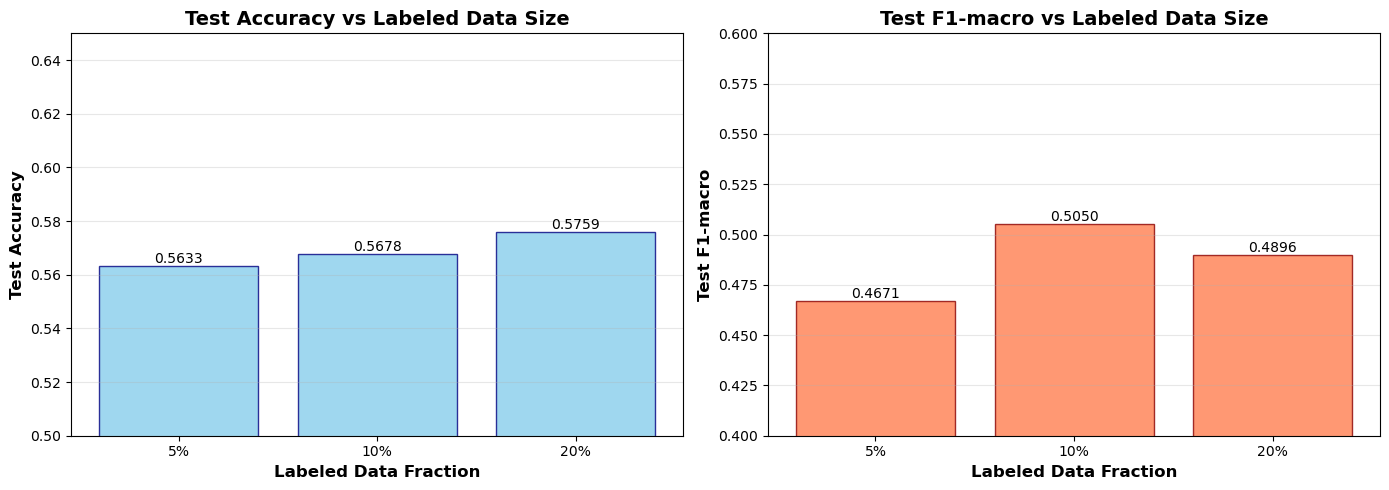

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
ax1 = axes[0]
x_labels = summary_df["Labeled %"].tolist()
accuracies = summary_df["Test Accuracy"].tolist()
f1_scores = summary_df["Test F1-macro"].tolist()

bars1 = ax1.bar(x_labels, accuracies, color='skyblue', alpha=0.8, edgecolor='navy')
ax1.set_xlabel("Labeled Data Fraction", fontsize=12, fontweight='bold')
ax1.set_ylabel("Test Accuracy", fontsize=12, fontweight='bold')
ax1.set_title("Test Accuracy vs Labeled Data Size", fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.5, 0.65])

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

# Plot 2: F1-macro
ax2 = axes[1]
bars2 = ax2.bar(x_labels, f1_scores, color='coral', alpha=0.8, edgecolor='darkred')
ax2.set_xlabel("Labeled Data Fraction", fontsize=12, fontweight='bold')
ax2.set_ylabel("Test F1-macro", fontsize=12, fontweight='bold')
ax2.set_title("Test F1-macro vs Labeled Data Size", fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.4, 0.6])

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plot_file = results_dir / "test_performance_comparison.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 2: Improvement over Baseline

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments\improvement_vs_baseline.png


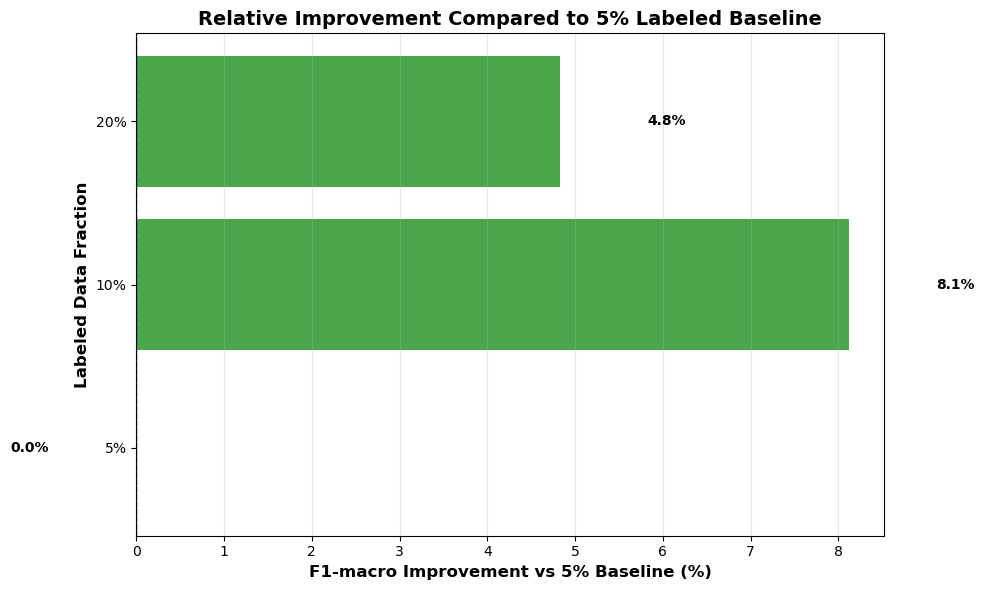

In [8]:
# Calculate improvement (assuming 5% is our baseline)
baseline_idx = summary_df[summary_df["Labeled %"] == "5%"].index[0]
baseline_f1 = summary_df.loc[baseline_idx, "Test F1-macro"]

summary_df["F1 Improvement"] = ((summary_df["Test F1-macro"] - baseline_f1) / baseline_f1 * 100)

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if x < 0 else 'green' for x in summary_df["F1 Improvement"]]
bars = ax.barh(summary_df["Labeled %"], summary_df["F1 Improvement"], color=colors, alpha=0.7)

ax.set_xlabel("F1-macro Improvement vs 5% Baseline (%)", fontsize=12, fontweight='bold')
ax.set_ylabel("Labeled Data Fraction", fontsize=12, fontweight='bold')
ax.set_title("Relative Improvement Compared to 5% Labeled Baseline", fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    label_x = width + (1 if width > 0 else -1)
    ax.text(label_x, bar.get_y() + bar.get_height()/2.,
            f'{width:.1f}%',
            ha='left' if width > 0 else 'right',
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plot_file = results_dir / "improvement_vs_baseline.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 3: Pseudo-labels Added

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments\pseudo_labels_comparison.png


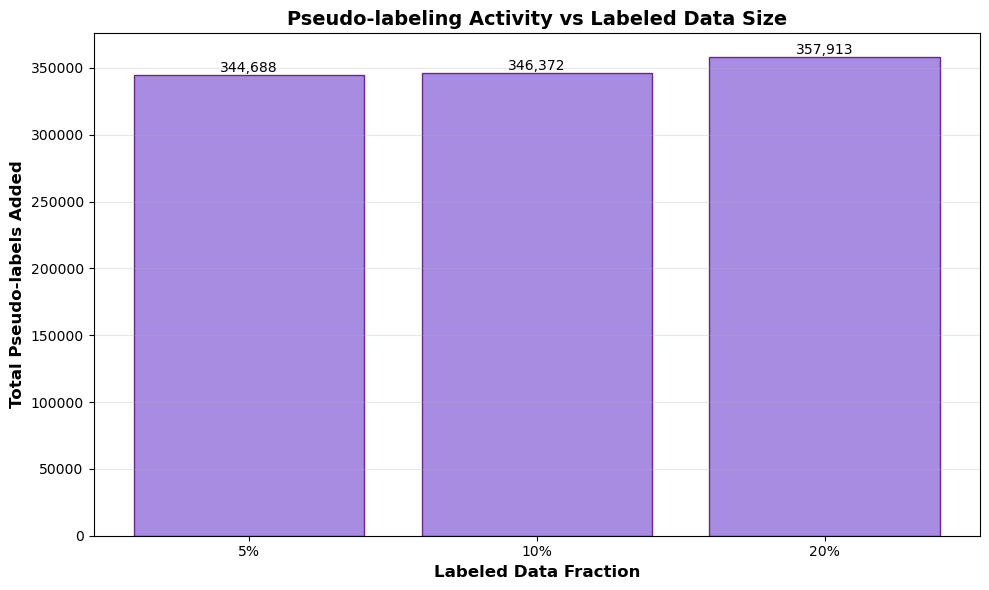

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

pseudo_counts = summary_df["Pseudo-labels Added"].tolist()
labeled_pcts = summary_df["Labeled %"].tolist()

bars = ax.bar(labeled_pcts, pseudo_counts, color='mediumpurple', alpha=0.8, edgecolor='indigo')
ax.set_xlabel("Labeled Data Fraction", fontsize=12, fontweight='bold')
ax.set_ylabel("Total Pseudo-labels Added", fontsize=12, fontweight='bold')
ax.set_title("Pseudo-labeling Activity vs Labeled Data Size", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plot_file = results_dir / "pseudo_labels_comparison.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 4: Training Data Growth

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments\training_data_composition.png


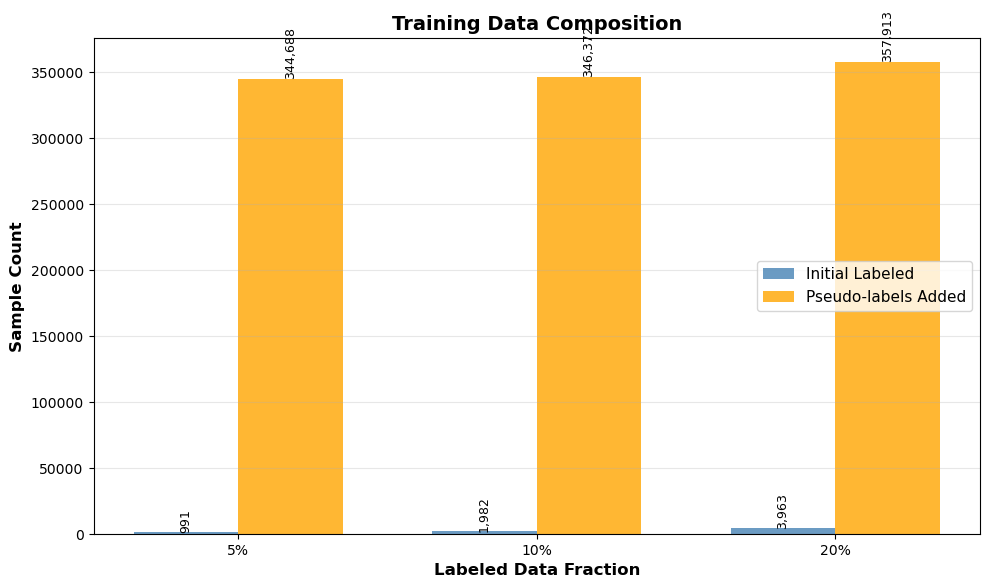

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(labeled_pcts))
width = 0.35

labeled_counts = summary_df["Labeled Count"].tolist()
pseudo_counts = summary_df["Pseudo-labels Added"].tolist()

bars1 = ax.bar(x - width/2, labeled_counts, width, label='Initial Labeled', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, pseudo_counts, width, label='Pseudo-labels Added', color='orange', alpha=0.8)

ax.set_xlabel("Labeled Data Fraction", fontsize=12, fontweight='bold')
ax.set_ylabel("Sample Count", fontsize=12, fontweight='bold')
ax.set_title("Training Data Composition", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labeled_pcts)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plot_file = results_dir / "training_data_composition.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 5: Learning Curves (F1 over Iterations)

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments\learning_curves.png


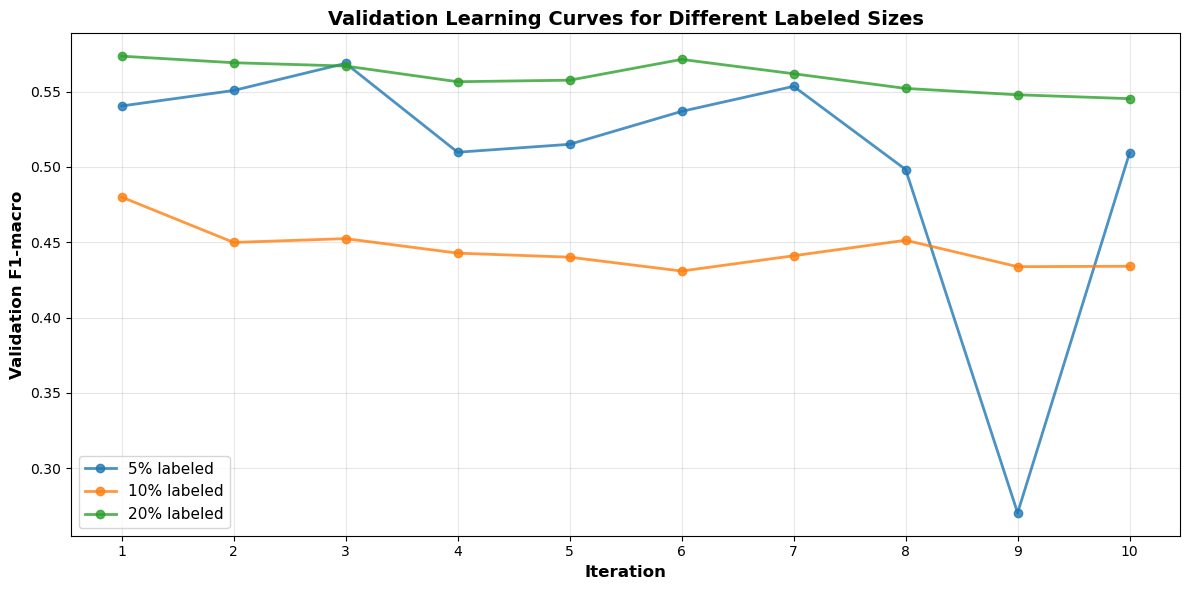

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

for key, res in results.items():
    history = res["history"]
    iterations = [h["iter"] for h in history]
    val_f1 = [h["val_f1_macro"] for h in history]
    
    ax.plot(iterations, val_f1, marker='o', linewidth=2, label=f'{key} labeled', alpha=0.8)

ax.set_xlabel("Iteration", fontsize=12, fontweight='bold')
ax.set_ylabel("Validation F1-macro", fontsize=12, fontweight='bold')
ax.set_title("Validation Learning Curves for Different Labeled Sizes", fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, 11))

plt.tight_layout()
plot_file = results_dir / "learning_curves.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Analysis & Insights

In [12]:
print("\n" + "="*100)
print("📊 KEY FINDINGS")
print("="*100)

# Find best configuration
best_idx = summary_df["Test F1-macro"].idxmax()
best_config = summary_df.loc[best_idx]

print(f"\n🏆 Best Configuration:")
print(f"   Labeled Fraction: {best_config['Labeled %']}")
print(f"   Test F1-macro: {best_config['Test F1-macro']:.4f}")
print(f"   Test Accuracy: {best_config['Test Accuracy']:.4f}")
print(f"   Pseudo-labels: {best_config['Pseudo-labels Added']:,}")

# Efficiency analysis
print(f"\n💡 Efficiency Analysis:")
for idx, row in summary_df.iterrows():
    efficiency = row["Test F1-macro"] / (row["Labeled Count"] / 1000)
    print(f"   {row['Labeled %']}: {efficiency:.4f} F1 per 1K labeled samples")

# Diminishing returns
print(f"\n📉 Diminishing Returns:")
for i in range(1, len(summary_df)):
    prev_f1 = summary_df.iloc[i-1]["Test F1-macro"]
    curr_f1 = summary_df.iloc[i]["Test F1-macro"]
    improvement = (curr_f1 - prev_f1) * 100
    prev_label = summary_df.iloc[i-1]["Labeled %"]
    curr_label = summary_df.iloc[i]["Labeled %"]
    print(f"   {prev_label} → {curr_label}: +{improvement:.2f}% F1 improvement")

print(f"\n✅ All visualizations saved to: {results_dir}")
print("="*100)


📊 KEY FINDINGS

🏆 Best Configuration:
   Labeled Fraction: 10%
   Test F1-macro: 0.5050
   Test Accuracy: 0.5678
   Pseudo-labels: 346,372

💡 Efficiency Analysis:
   5%: 0.4713 F1 per 1K labeled samples
   10%: 0.2548 F1 per 1K labeled samples
   20%: 0.1235 F1 per 1K labeled samples

📉 Diminishing Returns:
   5% → 10%: +3.79% F1 improvement
   10% → 20%: +-1.54% F1 improvement

✅ All visualizations saved to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments


## Summary for Dashboard

Export simplified data for Streamlit dashboard

In [13]:
# Create dashboard-friendly summary
dashboard_data = {
    "experiment_type": "labeled_size_comparison",
    "parameters": {
        "tau": TAU,
        "max_iter": MAX_ITER,
        "labeled_fractions": LABELED_FRACTIONS
    },
    "summary": summary_df.to_dict(orient='records'),
    "best_config": {
        "labeled_fraction": best_config["Labeled %"],
        "f1_macro": float(best_config["Test F1-macro"]),
        "accuracy": float(best_config["Test Accuracy"])
    },
    "visualizations": [
        "test_performance_comparison.png",
        "improvement_vs_baseline.png",
        "pseudo_labels_comparison.png",
        "training_data_composition.png",
        "learning_curves.png"
    ]
}

dashboard_file = results_dir / "dashboard_summary.json"
with open(dashboard_file, "w") as f:
    json.dump(dashboard_data, f, indent=2)

print(f"✅ Dashboard summary saved to: {dashboard_file}")
display(Markdown(f"## Experiment Complete! ✅\n\nAll results saved to: `{results_dir}`"))

✅ Dashboard summary saved to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments\dashboard_summary.json


## Experiment Complete! ✅

All results saved to: `D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\labeled_size_experiments`